# Import
Importing the required libraries


In [1]:
import git
import re
import py7zr
import numpy as np
import spacy
import scispacy
from imblearn.over_sampling import RandomOverSampler
from scispacy.abbreviation import AbbreviationDetector
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import sent2vec
from nltk import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from scipy.spatial import distance
import requests
import multiprocessing
from multiprocessing import Pool
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

2024-02-19 00:57:49.299367: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 00:57:49.299445: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 00:57:49.325560: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-19 00:57:49.383779: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-19 00:57:50.272550: W tensorflow/compiler/tf2

### Download the data

In [2]:
# # Cloning the git repository for the dataset
# def clone_repo(repo_url, directory=None):
#     try:
#         print(f"Cloning repository {repo_url} to {directory}...")
#         git.Repo.clone_from(repo_url, directory)
#         print("Repository cloned successfully.")
#     except Exception as e:
#         print(f"Failed to clone repository. Error: {e}")

# repo_url = "https://github.com/Franck-Dernoncourt/pubmed-rct.git"
# clone_repo(repo_url, "./data")
# # Extracting the training data from the 7z archive
# archive_path = 'data/PubMed_200k_RCT/train.7z'
# extract_path = 'data/PubMed_200k_RCT'

# with py7zr.SevenZipFile(archive_path, mode='r') as z:
#     z.extractall(path=extract_path)

### Loading th data

In [3]:
train_path = 'data/PubMed_200k_RCT/train.txt'
test_path = 'data/PubMed_200k_RCT/test.txt'
def load_data(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        # Initialize lists to hold labels and sentences
        labels = []
        sentences = []
        
        for line in file:
            # Skip empty lines and lines starting with '#'
            if line.strip() == '' or line.startswith('#'):
                continue
            
            # Split the line into label and sentence
            parts = line.strip().split('\t', 1)  # Split on the first tab only
            if len(parts) == 2:  # Ensure the line is correctly formatted
                label, sentence = parts
                labels.append(label.upper())  # Convert label to uppercase
                sentences.append(sentence)
                
    # Convert lists to NumPy arrays
    labels_array = np.array(labels)
    sentences_array = np.array(sentences)
    
    return labels_array, sentences_array


Since the classes are ordered (Objective then Methods then Results then Conclusions) except for Background that comes either first or last, we can use integer encoding

In [4]:
Y_train, X_train = load_data(train_path)
Y_test, X_test = load_data(test_path)
mapping = {'OBJECTIVE': 0, 'METHODS': 1, 'RESULTS': 2, 'CONCLUSIONS': 3, 'BACKGROUND': 4}
Y_train = np.vectorize(mapping.get)(Y_train)
Y_test = np.vectorize(mapping.get)(Y_test)
X_small = X_train[:1000]
Y_small = Y_train[:1000]

# Part 1: A baseline model with bag of words.

In [5]:
def sklearn_TFIDF(l, voc):
    skTFIDF_vectorizer = TfidfVectorizer(vocabulary=voc)
    sk_TFIDF = skTFIDF_vectorizer.fit_transform(l)
    sk_TFIDF_array = sk_TFIDF.toarray()
    return sk_TFIDF_array

def sklearn_TFIDF_wv(l):
    skTFIDF_vectorizer = TfidfVectorizer()
    sk_TFIDF = skTFIDF_vectorizer.fit_transform(l)
    sk_TFIDF_array = sk_TFIDF.toarray()
    voc = skTFIDF_vectorizer.get_feature_names_out()
    return sk_TFIDF_array, voc

In [6]:
X_small_TFIDF, vocabulary = sklearn_TFIDF_wv(X_small)  

We use the PCA to keep just the important vocabulary

In [7]:
pca = PCA(n_components=30)
X_pca = pca.fit_transform(X_small_TFIDF)
# Get the loadings of the first principal component
loadings = pca.components_

# For each component, identify the top contributing features
top_n = 20  # Number of top features to list for each component
feature_names = vocabulary
top_features = []

for i, component in enumerate(loadings):
    # Sort the features by the absolute value of their loadings
    sorted_idx = np.argsort(np.abs(component))[::-1]
    top_features.append(feature_names[sorted_idx][:top_n])
top_features = np.concatenate(top_features)
top_features = np.unique(top_features.astype(str))
top_features.shape

(143,)

We Validate the model using the train data to avoid data leakage

In [8]:
X_train_TFIDF = sklearn_TFIDF(X_train[:10000], top_features)
X_Validation_TFIDF = sklearn_TFIDF(X_train[10000:30000], top_features)
Y_Validation = Y_train[10000:30000]

We balance the training dataset to avoid bias

In [9]:
unique_values, counts = np.unique(Y_train[:10000], return_counts=True)
print("Count of each unique value in the array before oversampling: ")
for value, count in zip(unique_values, counts):
    print(f"Value {value} appears {count} times")

Count of each unique value in the array before oversampling: 
Value 0 appears 772 times
Value 1 appears 3317 times
Value 2 appears 3451 times
Value 3 appears 1543 times
Value 4 appears 917 times


In [10]:
ros = RandomOverSampler(random_state=42)

X_resampled, y_train_resampled = ros.fit_resample(X_train_TFIDF, Y_train[:10000])

In [11]:
unique_values, counts = np.unique(y_train_resampled, return_counts=True)
print("Count of each unique value in the array after oversampling: ")
for value, count in zip(unique_values, counts):
    print(f"Value {value} appears {count} times")

Count of each unique value in the array after oversampling: 
Value 0 appears 3451 times
Value 1 appears 3451 times
Value 2 appears 3451 times
Value 3 appears 3451 times
Value 4 appears 3451 times


Now we train 3 different classification models: SVM, Logistic Regression and Random Forest. We will use the validation set to evaluate the performance of the models.

In [12]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    print(f'Precision: {precision}, Recall: {recall}, F-score: {fscore}')
    return confusion_matrix(y_test, y_pred)


def plot_confusion_matrix(conf_matrix, title='Confusion Matrix'):
    plt.figure(figsize=(10,7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

SVM Model Evaluation
Precision: 0.6636357683872192, Recall: 0.623, F-score: 0.635046714505929


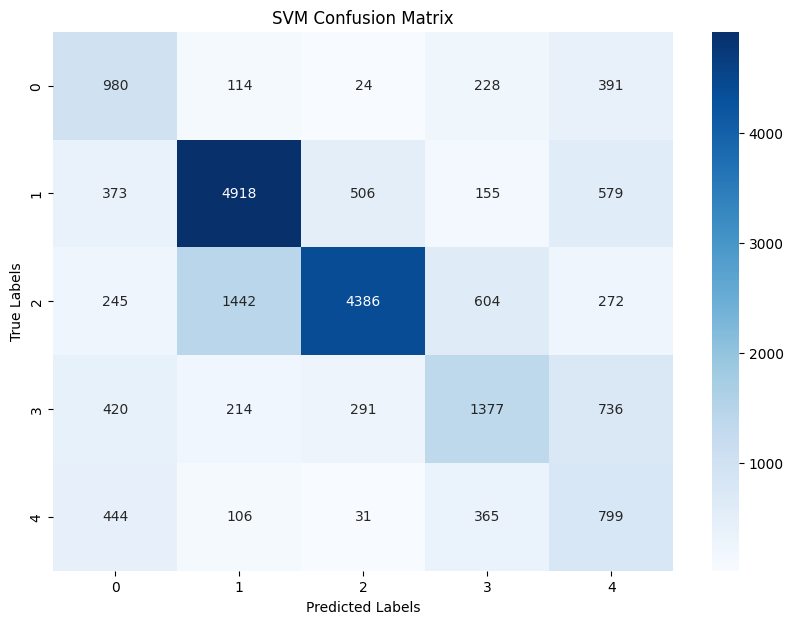

In [13]:
model_SVM = svm.SVC(kernel='linear')
model_SVM.fit(X_resampled, y_train_resampled)
print("SVM Model Evaluation")
conf_matrix_baseline = evaluate_model(model_SVM, X_Validation_TFIDF, Y_Validation)
plot_confusion_matrix(conf_matrix_baseline, title='SVM Confusion Matrix')


Logistic Regression Model Evaluation
Precision: 0.6573498422530514, Recall: 0.62455, F-score: 0.6354888017021281


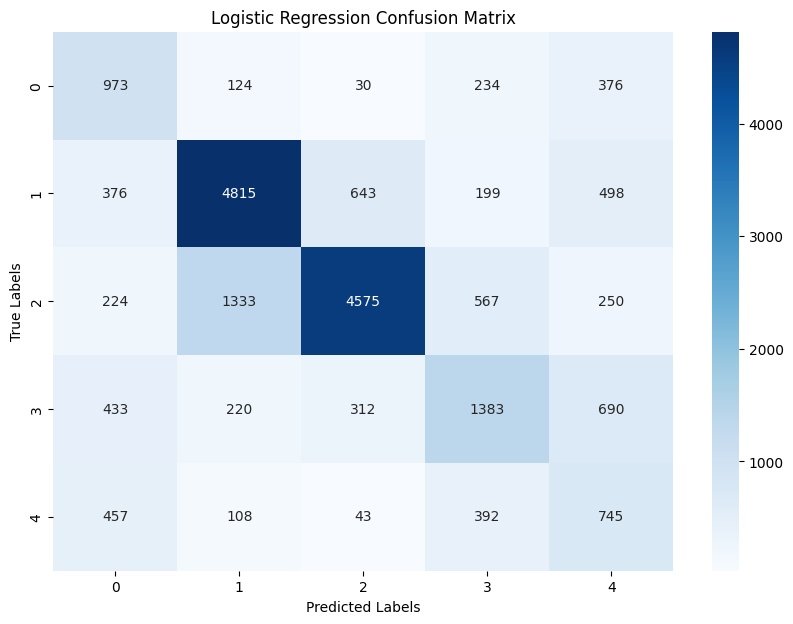

In [14]:
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_resampled, y_train_resampled)
print("\nLogistic Regression Model Evaluation")
conf_matrix_lr = evaluate_model(model_lr, X_Validation_TFIDF, Y_Validation)
plot_confusion_matrix(conf_matrix_lr, title='Logistic Regression Confusion Matrix')


Random Forest Model Evaluation
Precision: 0.6448782978699719, Recall: 0.64475, F-score: 0.6435696678158003


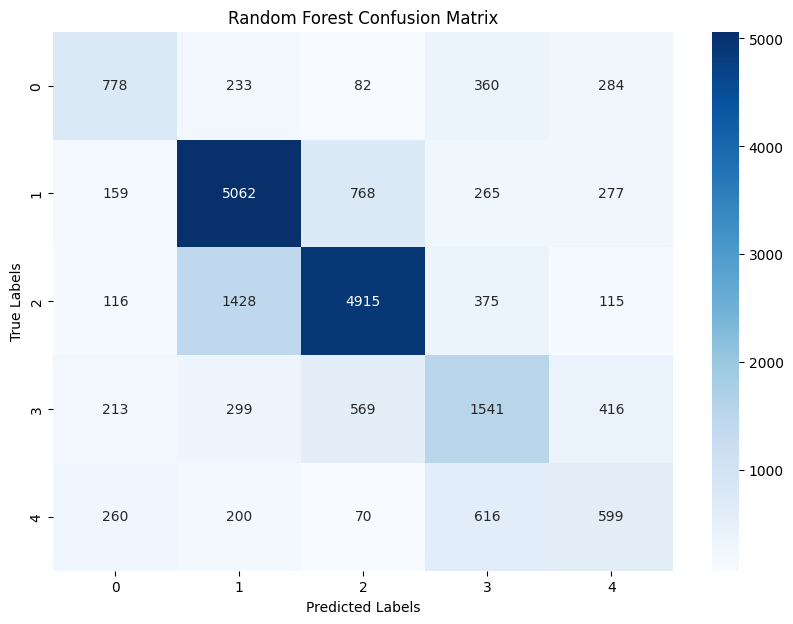

In [15]:
model_rf = RandomForestClassifier(n_estimators=100)
model_rf.fit(X_resampled, y_train_resampled)
print("\nRandom Forest Model Evaluation")
conf_matrix_rf = evaluate_model(model_rf, X_Validation_TFIDF, Y_Validation)
plot_confusion_matrix(conf_matrix_rf, title='Random Forest Confusion Matrix')

Since the SVM model has the highest precision, recall and f-score, we will train it on a bigger dataset and use it to predict the labels of the test data

In [16]:
pca = PCA(n_components=250)
X_pca = pca.fit_transform(X_small_TFIDF)
# Get the loadings of the first principal component
loadings = pca.components_

# For each component, identify the top contributing features
top_n = 50  # Number of top features to list for each component
feature_names = vocabulary
top_features = []

for i, component in enumerate(loadings):
    # Sort the features by the absolute value of their loadings
    sorted_idx = np.argsort(np.abs(component))[::-1]
    top_features.append(feature_names[sorted_idx][:top_n])
top_features = np.concatenate(top_features)
top_features = np.unique(top_features.astype(str))
top_features.shape

(1110,)

In [17]:
X_train_TFIDF = sklearn_TFIDF(X_train[:100000], top_features)
X_test_TFIDF = sklearn_TFIDF(X_test, top_features)

We balance the training dataset

In [18]:
unique_values, counts = np.unique(Y_train[:100000], return_counts=True)
print("Count of each unique value in the array before oversampling: ")
for value, count in zip(unique_values, counts):
    print(f"Value {value} appears {count} times")

Count of each unique value in the array before oversampling: 
Value 0 appears 8440 times
Value 1 appears 32699 times
Value 2 appears 34784 times
Value 3 appears 15218 times
Value 4 appears 8859 times


In [19]:
ros = RandomOverSampler(random_state=42)

X_resampled, y_train = ros.fit_resample(X_train_TFIDF, Y_train[:100000])

In [20]:
unique_values, counts = np.unique(y_train, return_counts=True)
print("Count of each unique value in the array after oversampling: ")
for value, count in zip(unique_values, counts):
    print(f"Value {value} appears {count} times")

Count of each unique value in the array after oversampling: 
Value 0 appears 34784 times
Value 1 appears 34784 times
Value 2 appears 34784 times
Value 3 appears 34784 times
Value 4 appears 34784 times


SVM Model Evaluation
Precision: 0.7626171213685632, Recall: 0.7503475400942596, F-score: 0.7546631915923145


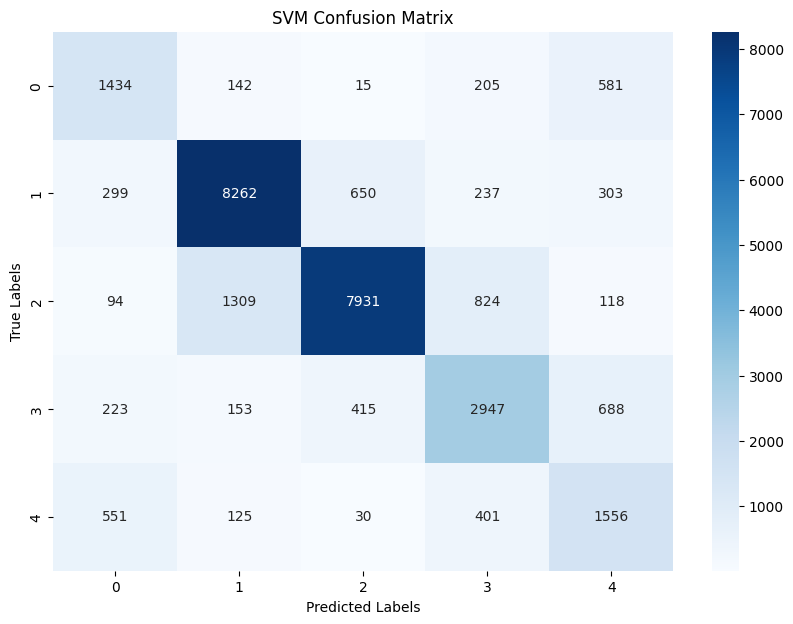

In [21]:
model_SVM = svm.SVC(kernel='linear')
model_SVM.fit(X_resampled, y_train)
print("SVM Model Evaluation")
conf_matrix_baseline = evaluate_model(model_SVM, X_test_TFIDF, Y_test)
plot_confusion_matrix(conf_matrix_baseline, title='SVM Confusion Matrix')

# Part 2: A model with pre-trained biomedical sentence embeddings. (Biosentvec)

We start by download and load the pre-trained model

In [22]:
# download_link = 'https://ftp.ncbi.nlm.nih.gov/pub/lu/Suppl/BioSentVec/BioSentVec_PubMed_MIMICIII-bigram_d700.bin'
# model_path = 'Downloaded_Models_BioSentVec_PubMed_MIMICIII-bigram_d700.bin'
# response = requests.get(download_link)
# if response.status_code == 200:
#     with open(model_path, 'wb') as f:
#         f.write(response.content)
#     print('Model downloaded')
# else:
#     print('Failed to download the model')

# model = sent2vec.Sent2vecModel()
# try:
#     model.load_model(model_path)
# except Exception as e:
#     print(e)
# print('model successfully loaded')

In [23]:
#this code is to avoid downloading the model every time we run the code, it should be deleted before submition, if you are reading it, please ignore it
model_path = '/home/karim/magistere/S6/Bio/projet/Partie 2/BioSentVec_PubMed_MIMICIII-bigram_d700.bin'
model = sent2vec.Sent2vecModel()
try:
    model.load_model(model_path)
except Exception as e:
    print(e)
print('model successfully loaded')

model successfully loaded


this function is used to preprocess the text using spacy by removing punctuations and lemmatizing the text


In [24]:
def scispacy_text_preprocessing(text):
    nlp = spacy.load('en_core_sci_sm')
    if not any([pipe[0] == 'AbbreviationDetector' for pipe in nlp.pipeline]):
        nlp.add_pipe("abbreviation_detector")
    doc = nlp(text)
    expanded_text = text
    for abbr in sorted(doc._.abbreviations, key=lambda a: a.start_char, reverse=True):
        abbr_expanded = abbr._.long_form.text
        expanded_text = expanded_text[:abbr.start_char] + abbr_expanded + expanded_text[abbr.end_char:]
    text = expanded_text
    doc = nlp(text)
    tokens2 = [token.text for token in doc]
    Vocab2 = list(set(tokens2))
    phrases2 = [sent.text for sent in doc.sents]
    lemmatized_tokens2 = []
    for token in doc:
        lemmatized_tokens2.append(token.lemma_)
    lemmatized_tokens2 = list(set(lemmatized_tokens2))
    return ' '.join(lemmatized_tokens2)

def sent2vec_embedding(text):
    return model.embed_sentence(scispacy_text_preprocessing(text))

In [25]:
X_small = np.array([sent2vec_embedding(str(text)) for text in X_small])
X_small = X_small.reshape(1000, 700)

/home/karim/miniconda3/lib/python3.11/site-packages/spacy/language.py:2141: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]
/home/karim/miniconda3/lib/python3.11/site-packages/scispacy/abbreviation.py:248: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  global_matches = self.global_matcher(doc)


In [26]:
ros = RandomOverSampler(random_state=42)

X_resampled, y_small = ros.fit_resample(X_small, Y_small)

In [27]:
unique_values, counts = np.unique(y_small, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"Value {value} appears {count} times")

Value 0 appears 345 times
Value 1 appears 345 times
Value 2 appears 345 times
Value 3 appears 345 times
Value 4 appears 345 times


The validation dataset

In [28]:
X_val = np.array([sent2vec_embedding(str(text)) for text in X_train[1000:2000]])
X_val = X_val.reshape(1000, 700)
y_val = Y_train[1000:2000]

/home/karim/miniconda3/lib/python3.11/site-packages/scispacy/abbreviation.py:248: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  global_matches = self.global_matcher(doc)


We do the same thing as before, we try 3 different models and we evaluate them and we chose the best one

SVM Model Evaluation
Precision: 0.6454514959824973, Recall: 0.653, F-score: 0.646504745621653


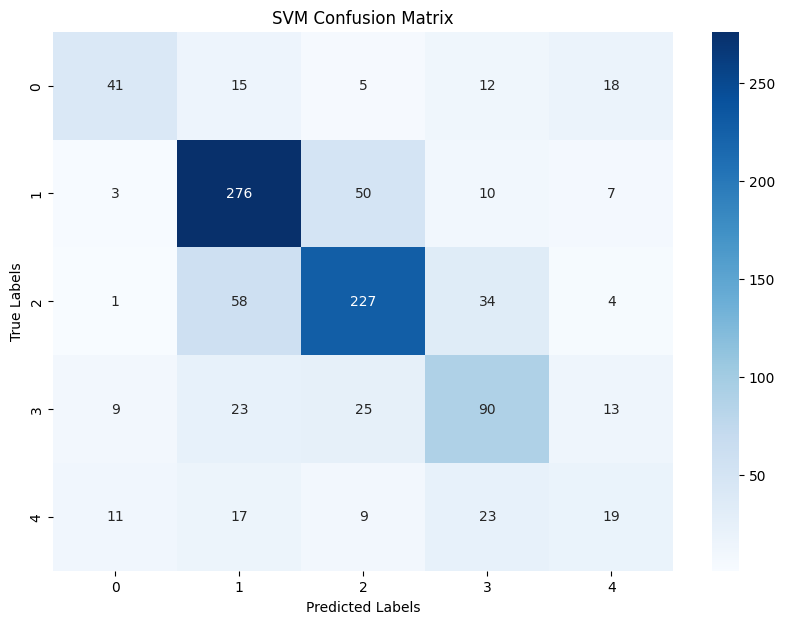

In [29]:
model_SVM = svm.SVC(kernel='linear')
model_SVM.fit(X_resampled, y_small)
print("SVM Model Evaluation")
conf_matrix_baseline = evaluate_model(model_SVM, X_val, y_val)
plot_confusion_matrix(conf_matrix_baseline, title='SVM Confusion Matrix')


Logistic Regression Model Evaluation
Precision: 0.6745218930016185, Recall: 0.671, F-score: 0.6700277853770813


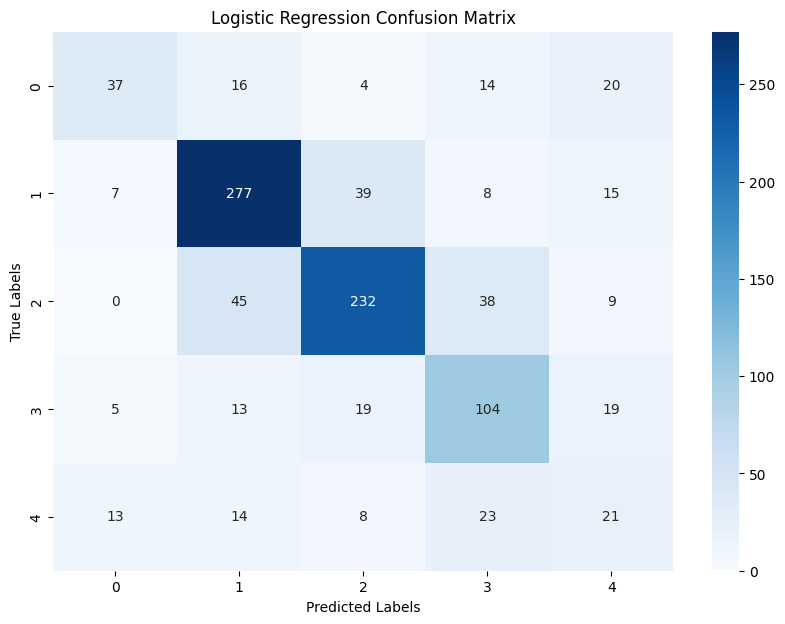

In [30]:
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_resampled, y_small)
print("\nLogistic Regression Model Evaluation")
conf_matrix_lr = evaluate_model(model_lr, X_val, y_val)
plot_confusion_matrix(conf_matrix_lr, title='Logistic Regression Confusion Matrix')


Random Forest Model Evaluation
Precision: 0.5345330467344833, Recall: 0.549, F-score: 0.4938508228597602


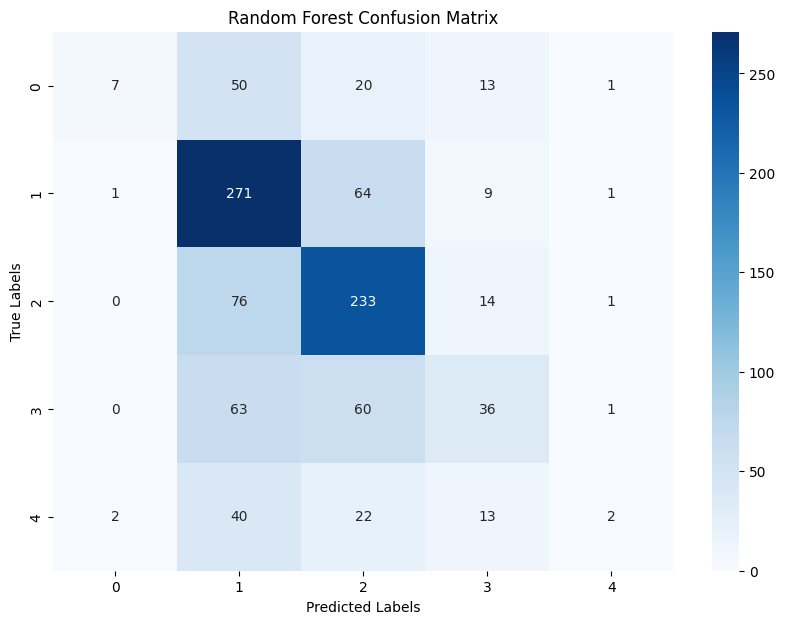

In [31]:
model_rf = RandomForestClassifier(n_estimators=100)
model_rf.fit(X_resampled, y_small)
print("\nRandom Forest Model Evaluation")
conf_matrix_rf = evaluate_model(model_rf, X_val, y_val)
plot_confusion_matrix(conf_matrix_rf, title='Random Forest Confusion Matrix')

This time the Logistic Regression has the best performance, so we will train it on a bigger dataset to evaluate the test dataset

In [32]:
y_train2 = Y_train[:50000]
y_test2 = Y_test[:50000]

Since this part takes a lot of time we will use multiprocessing library to divide the task between 5 CPU cores

In [33]:
def function(core_id, size = 10000):
    start = size * core_id
    end = start + size
    print("Starting core id", core_id, "from", start, "to", end)
    X_test_i = np.array([sent2vec_embedding(str(text)) for text in X_test[start:end]]) 
    X_train_i = np.array([sent2vec_embedding(str(text)) for text in X_train[start:end]])

    
    return {
        "core_id": core_id,
        "X_tt": X_test_i,
        "X_tr": X_train_i
    }
cores = 5
if __name__ == "__main__":
    with Pool(cores) as p:
        results = p.map(function, range(cores))

Starting core idStarting core idStarting core idStarting core idStarting core id    2 03  14fromfrom    from from20000from 0 to 10000  40000 30000to30000    to10000to
 
to 4000050000 
20000



/home/karim/miniconda3/lib/python3.11/site-packages/scispacy/abbreviation.py:248: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  global_matches = self.global_matcher(doc)
/home/karim/miniconda3/lib/python3.11/site-packages/scispacy/abbreviation.py:248: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  global_matches = self.global_matcher(doc)
/home/karim/miniconda3/lib/python3.11/site-packages/scispacy/abbreviation.py:248: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  global_matches = self.global_matcher(doc)
/home/karim/miniconda3/lib/python3.11/site-packages/scispacy/abbreviation.py:248: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  global_matches = self.global_matcher(doc)
/home/karim/miniconda3/lib/python3.11/site-packages/scispacy/abbreviation.py:248: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  global_match

In [34]:
X_test2 = results[0]["X_tt"]
X_test2 = np.concatenate((X_test2, results[1]["X_tt"]))
X_test2 = np.concatenate((X_test2, results[2]["X_tt"]))
X_train2 = results[0]["X_tr"]

for result in results[1:]:
        X_train2 = np.concatenate((X_train2, result["X_tr"]), axis=0)

X_train2 = X_train2.reshape(50000, 700)
l = X_test2.shape[0]
X_test2 = X_test2.reshape(l, 700)

In [35]:
ros = RandomOverSampler(random_state=42)

X_resampled2, y_train2 = ros.fit_resample(X_train2, y_train2)

In [36]:
unique_values, counts = np.unique(y_train2, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"Value {value} appears {count} times")

Value 0 appears 17380 times
Value 1 appears 17380 times
Value 2 appears 17380 times
Value 3 appears 17380 times
Value 4 appears 17380 times



Logistic Regression Model Evaluation
Precision: 0.7527717046625801, Recall: 0.7356999966093649, F-score: 0.7422547822645834


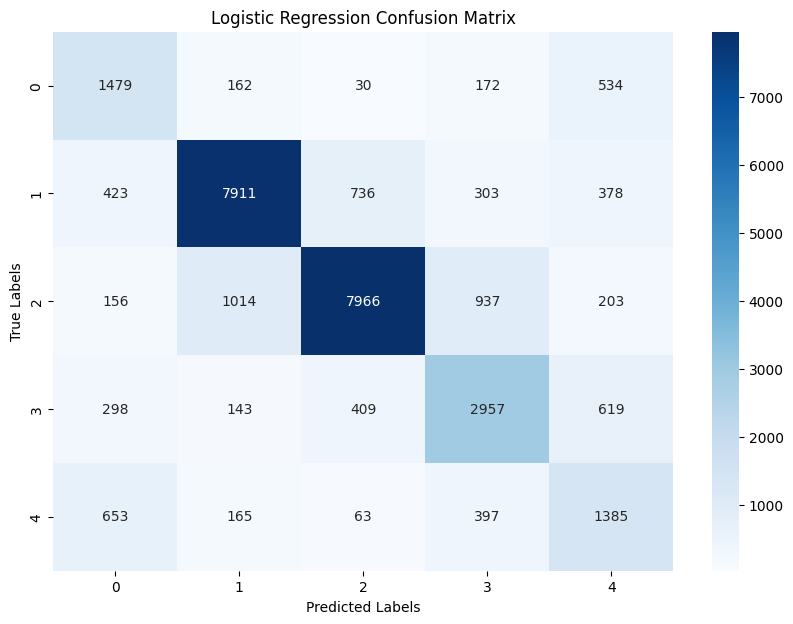

In [40]:
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_resampled2, y_train2)
print("\nLogistic Regression Model Evaluation")
conf_matrix_lr = evaluate_model(model_lr, X_test2, y_test2)
plot_confusion_matrix(conf_matrix_lr, title='Logistic Regression Confusion Matrix')

# Part 3: A deep learning based model. 

In [38]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_resampled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(5, activation='softmax')  
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  
              metrics=['accuracy'])
history = model.fit(X_resampled2, y_train2, epochs=10, validation_split=0.2)

Epoch 1/10
2173/2173 [==============================] - 4s 2ms/step - loss: 0.7175 - accuracy: 0.7394 - val_loss: 1.6448 - val_accuracy: 0.3041
Epoch 2/10
2173/2173 [==============================] - 3s 2ms/step - loss: 0.5837 - accuracy: 0.7902 - val_loss: 1.2092 - val_accuracy: 0.4559
Epoch 3/10
2173/2173 [==============================] - 3s 2ms/step - loss: 0.5125 - accuracy: 0.8194 - val_loss: 1.1755 - val_accuracy: 0.4990
Epoch 4/10
2173/2173 [==============================] - 3s 1ms/step - loss: 0.4483 - accuracy: 0.8434 - val_loss: 0.9751 - val_accuracy: 0.6000
Epoch 5/10
2173/2173 [==============================] - 3s 2ms/step - loss: 0.3964 - accuracy: 0.8636 - val_loss: 1.4333 - val_accuracy: 0.4537
Epoch 6/10
2173/2173 [==============================] - 3s 2ms/step - loss: 0.3522 - accuracy: 0.8784 - val_loss: 1.0080 - val_accuracy: 0.5829
Epoch 7/10
2173/2173 [==============================] - 3s 2ms/step - loss: 0.3141 - accuracy: 0.8924 - val_loss: 0.8134 - val_accuracy:

922/922 [==============================] - 1s 757us/step
Precision: 0.7546733851358133, Recall: 0.7541789577187807, F-score: 0.7539848153336111


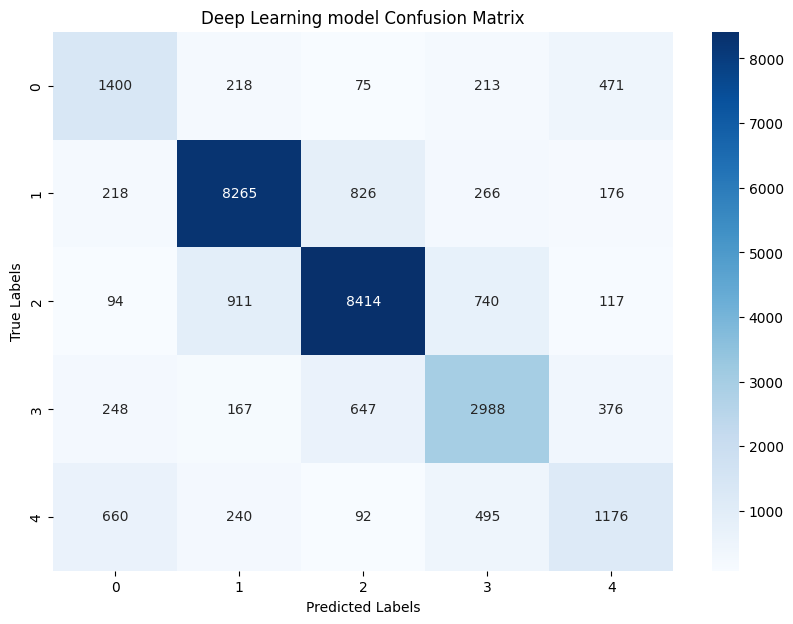

In [39]:
y_pred_prob = model.predict(X_test2)  # Model's probability predictions for each class
# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

precision, recall, fscore, _ = precision_recall_fscore_support(y_test2, y_pred, average='weighted')
print(f'Precision: {precision}, Recall: {recall}, F-score: {fscore}')
plot_confusion_matrix( confusion_matrix(y_test2, y_pred) , title='Deep Learning model Confusion Matrix')